In [1]:
import numpy as np
import ROOT
from math import exp as expo
from math import cos as cosine
exp=np.vectorize(expo)
cos=np.vectorize(cosine)
import matplotlib.pylab as plt
from matplotlib.pyplot import figure
from BlindersPy3 import Blinders
from BlindersPy3 import FitType
import scipy.optimize as opt

Welcome to JupyROOT 6.24/06


In [2]:
file = ROOT.TFile.Open("run3b_NE_305stop.root")
#file = ROOT.TFile.Open("run3b_33start.root")
#direc = file.Get("QFillByFillAnalyzerDB")
hist = ROOT.TH1D()
hist = file.Get("calo_histogram_sum_ratio")
hcov = ROOT.TH2D()
hcov = file.Get("hcov")

#loss_file = ROOT.TFile.Open("LostMuonsSpectra.root")
#direc = loss_file.Get("Run3b")
#hlm = ROOT.TH1F()
#hlm = direc.Get("triple_losses_spectra_integral")

#loss_file_2 = ROOT.TFile.Open("reconEmuonloss.root")
#direc = loss_file.Get("Run3a")
#hlm_2 = ROOT.TH1D()
#hlm_2 = loss_file_2.Get("lambda3B")

In [3]:
loss_file = ROOT.TFile.Open("reconWmuonloss3b_mod.root")
hlm = ROOT.TH1F()
hlm = loss_file.Get("hI")

loss_file_2 = ROOT.TFile.Open("reconEmuonloss3b_mod.root")
hlm_2 = ROOT.TH1F()
hlm_2 = loss_file_2.Get("hI")

In [4]:
hlm.Scale(1.0/hlm.GetBinContent(hlm.GetNbinsX()))
hlm_2.Scale(1.0/hlm_2.GetBinContent(hlm_2.GetNbinsX()))

In [5]:
getBlinded = Blinders(FitType.Omega_a, "Ritwika's new  Blinding")

 + ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ +
 +                                                                      +
 +           You have chose to blind your fitting according to          +
 +                omega_ref * (1 + (R +/- deltaR) *10^{-6})             +
 +                                                                      +
 + ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++ +


In [6]:
fit_start=30000
fit_stop=305000
fit_range=hist.FindBin(fit_stop)-hist.FindBin(fit_start)+1

T_a_true=4365.411
nbinshift=int((0.5*T_a_true)/hist.GetBinWidth(1))
T_a=2*nbinshift*hist.GetBinWidth(1)

y_val=np.empty(fit_range)
y_err=np.empty(fit_range)
x_val=np.empty(fit_range)
x_mloss=np.empty(fit_range)
y_mloss=np.empty(fit_range)
x_mloss_2=np.empty(fit_range)
y_mloss_2=np.empty(fit_range)

for ibin in range (0,fit_range):
    y_val[ibin]=hist.GetBinContent(ibin+hist.FindBin(fit_start))
    y_err[ibin]=hist.GetBinError(ibin+hist.FindBin(fit_start))
    x_val[ibin]=hist.GetBinCenter(ibin+hist.FindBin(fit_start))
    x_mloss[ibin]=hlm.GetBinCenter(ibin+hlm.FindBin(fit_start))
    y_mloss[ibin]=hlm.GetBinContent(ibin+hlm.FindBin(fit_start))
    x_mloss_2[ibin]=hlm_2.GetBinCenter(ibin+hlm_2.FindBin(fit_start))
    y_mloss_2[ibin]=hlm_2.GetBinContent(ibin+hlm_2.FindBin(fit_start))

y_cov = np.empty(shape=(fit_range,fit_range))

for irow in range (0, fit_range):
      for icol in range(0, fit_range):
            y_cov[irow][icol]=hcov.GetBinContent(irow+hist.FindBin(fit_start),icol+hist.FindBin(fit_start))

In [7]:
x_mloss[1]

30212.999999999996

In [8]:
print(y_cov[0][0])
mat=np.linalg.eigvalsh(y_cov)
for irow in range (0, fit_range):
    if mat[irow]<=0:
        print(irow,"\n")

8.270095283876686e-09


In [9]:
y_mlossf=np.empty(fit_range)
y_mlossb=np.empty(fit_range)

y_mlossf_2=np.empty(fit_range)
y_mlossb_2=np.empty(fit_range)

for ibin in range (0,fit_range):
    y_mlossf[ibin]=hlm.GetBinContent(ibin+hlm.FindBin(fit_start)+nbinshift)
    y_mlossb[ibin]=hlm.GetBinContent(ibin+hlm.FindBin(fit_start)-nbinshift) 
    y_mlossf_2[ibin]=hlm_2.GetBinContent(ibin+hlm_2.FindBin(fit_start)+nbinshift)
    y_mlossb_2[ibin]=hlm_2.GetBinContent(ibin+hlm_2.FindBin(fit_start)-nbinshift)

In [10]:
x_mloss[-25]

300115.79999999993

In [11]:
y_mlossb[-5]

0.14257654547691345

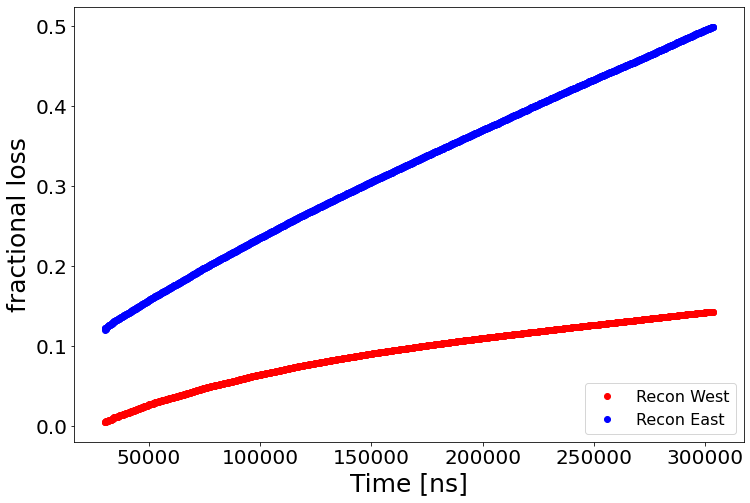

In [13]:
plt.figure(figsize=(12,8))
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
#plt.scatter(x_mloss_2, y_mloss_2, s=0.9, color='red', label='Data')
plt.errorbar(x_mloss, y_mloss, fmt="o", color='Red', label='Recon West')
#plt.scatter(x_mloss, y_mlossf, s=0.9, color='black', label='Data')
#plt.scatter(x_mloss, y_mlossb, s=0.9, color='red', label='Data')
plt.errorbar(x_mloss_2, y_mloss_2, fmt="o", color='blue', label='Recon East')
#plt.scatter(x_mloss_2, y_mlossf_2, s=0.9, color='orange', label='Data')
#plt.scatter(x_mloss_2, y_mlossb_2, s=0.9, color='gray', label='Data')
#plt.plot(x_val, fit, linestyle='--', linewidth=1, color='red')
plt.xlabel('Time [ns]',fontsize=25)
plt.ylabel('fractional loss',fontsize=25)
plt.legend(loc=4, prop={'size': 16})
#plt.ylim([0.08,0.17])
#plt.xlim([25000,40000])
plt.show()

In [13]:
def fit_func(time: np.double,
             asym: np.double = 0.0, 
             R: np.double = 0.0, 
             phi: np.double = 0.0,
             asym_cbo = 0.0,
             tau_cbo = 0.0,
             omega_cbo = 0.0,
             phi_cbo = 0.0,
             asym_cbo_A = 0.0,
             phi_cbo_A=0.0,
             A_cbo_phi= 0.0,
             phi_cbo_phi=0.0,
             asym_vw= 0.0,
             tau_vw = 0.0,
             omega_vw = 0.0,
             phi_vw = 0.0,
             asym_vbo= 0.0,
             tau_vbo = 0.0,
             omega_vbo = 0.0,
             phi_vbo = 0.0,
             asym_2cbo= 0.0,
             phi_2cbo = 0.0,
             tau_rlx = 0.0,
             A_cbovw = 0.0,
             phi_cbovw = 0.0)-> np.double:
    
    tau_cbovw = 34200
    omega_cbovw = 0.01204
      
     
    Ncbo=(1 + asym_cbo*exp(-time/tau_cbo)*cos(omega_cbo*time - phi_cbo))
    Ncbof=(1+ asym_cbo*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbo*(time + T_a/2) - phi_cbo))
    Ncbob=(1+ asym_cbo*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbo*(time - T_a/2) - phi_cbo))
    
    Acbo=(1+ asym_cbo_A*exp(-time/tau_cbo)*cos(omega_cbo*time - phi_cbo_A));
    Acbof=(1+ asym_cbo_A*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbo*(time + T_a/2) - phi_cbo_A))
    Acbob=(1+ asym_cbo_A*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbo*(time - T_a/2) - phi_cbo_A))
    
    phicbo=(A_cbo_phi*exp(-time/tau_cbo)*cos(omega_cbo*time - phi_cbo_phi))
    phicbof=(A_cbo_phi*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbo*(time + T_a/2) - phi_cbo_phi))
    phicbob=(A_cbo_phi*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbo*(time - T_a/2) - phi_cbo_phi))
    
    Nvw=(1+ asym_vw*exp(-time/tau_vw)*cos(omega_vw*time - phi_vw))
    Nvwf=(1+ asym_vw*exp(-(time + T_a/2)/tau_vw)*cos(omega_vw*(time + T_a/2) - phi_vw))
    Nvwb=(1+ asym_vw*exp(-(time - T_a/2)/tau_vw)*cos(omega_vw*(time - T_a/2) - phi_vw))
    
    Nvbo=(1+ asym_vbo*exp(-time/tau_vbo)*cos(omega_vbo*time - phi_vbo))
    Nvbof=(1+ asym_vbo*exp(-(time + T_a/2)/tau_vbo)*cos(omega_vbo*(time + T_a/2) - phi_vbo))
    Nvbob=(1+ asym_vbo*exp(-(time - T_a/2)/tau_vbo)*cos(omega_vbo*(time - T_a/2) - phi_vbo))
    
    N2cbo=(asym_2cbo*exp(-2*time/tau_cbo)*cos(2*omega_cbo*time - phi_2cbo))
    N2cbof=(asym_2cbo*exp(-2*(time + T_a/2)/tau_cbo)*cos(2*omega_cbo*(time + T_a/2) - phi_2cbo))
    N2cbob=(asym_2cbo*exp(-2*(time - T_a/2)/tau_cbo)*cos(2*omega_cbo*(time - T_a/2) - phi_2cbo))
    
    Ncbovw=(1+ A_cbovw*exp(-time/tau_cbovw)*cos(omega_cbovw*time - phi_cbovw))
    Ncbovwf=(1+ A_cbovw*exp(-(time + T_a/2)/tau_cbovw)*cos(omega_cbovw*(time + T_a/2) - phi_cbovw))
    Ncbovwb=(1+ A_cbovw*exp(-(time - T_a/2)/tau_cbovw)*cos(omega_cbovw*(time - T_a/2) - phi_cbovw))

    
    Ncbo=Ncbo+N2cbo
    Ncbof=Ncbof+N2cbof
    Ncbob=Ncbob+N2cbob

    
    f=(1+ asym*exp(-time/tau_rlx)*Acbo*cos((getBlinded.paramToFreq(R)/1000.)*time - phi - phicbo))

    ff=(1+ asym*exp(-(time+T_a/2)/tau_rlx)*Acbof*cos((getBlinded.paramToFreq(R)/1000.)*(time + T_a/2) - phi - phicbof))

    fb=(1+ asym*exp(-(time-T_a/2)/tau_rlx)*Acbob*cos((getBlinded.paramToFreq(R)/1000.)*(time - T_a/2) - phi - phicbob))

    
    return (2*f*Ncbo*Nvw*Nvbo*Ncbovw - ff*Ncbof*Nvwf*Nvbof*Ncbovwf - fb*Ncbob*Nvwb*Nvbob*Ncbovwb)/(2*f*Ncbo*Nvw*Nvbo*Ncbovw + ff*Ncbof*Nvwf*Nvbof*Ncbovwf + fb*Ncbob*Nvwb*Nvbob*Ncbovwb)

In [14]:
def fit_func_RW(time: np.double,
                asym: np.double = 0.0, 
                R: np.double = 0.0, 
                phi: np.double = 0.0,
                asym_cbo = 0.0,
                tau_cbo = 0.0,
                omega_cbo = 0.0,
                phi_cbo = 0.0,
                asym_cbo_A = 0.0,
                phi_cbo_A=0.0,
                A_cbo_phi= 0.0,
                phi_cbo_phi=0.0,
                asym_vw= 0.0,
                tau_vw = 0.0,
                omega_vw = 0.0,
                phi_vw = 0.0,
                asym_vbo= 0.0,
                tau_vbo = 0.0,
                omega_vbo = 0.0,
                phi_vbo = 0.0,
                asym_2cbo= 0.0,
                phi_2cbo = 0.0,
                tau_rlx = 0.0,
                A_cbovw = 0.0,
                phi_cbovw = 0.0)-> np.double:
    
    
    tau_cbovw = 34200
    omega_cbovw = 0.01204
    
   
    
    A_lm=-0.00960 #30 us st
    #A_lm=-0.00136 #33 us st
    
    Ncbo=(1 + asym_cbo*exp(-time/tau_cbo)*cos(omega_cbo*time - phi_cbo))
    Ncbof=(1+ asym_cbo*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbo*(time + T_a/2) - phi_cbo))
    Ncbob=(1+ asym_cbo*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbo*(time - T_a/2) - phi_cbo))
    
    Acbo=(1+ asym_cbo_A*exp(-time/tau_cbo)*cos(omega_cbo*time - phi_cbo_A));
    Acbof=(1+ asym_cbo_A*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbo*(time + T_a/2) - phi_cbo_A))
    Acbob=(1+ asym_cbo_A*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbo*(time - T_a/2) - phi_cbo_A))
    
    phicbo=(A_cbo_phi*exp(-time/tau_cbo)*cos(omega_cbo*time - phi_cbo_phi))
    phicbof=(A_cbo_phi*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbo*(time + T_a/2) - phi_cbo_phi))
    phicbob=(A_cbo_phi*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbo*(time - T_a/2) - phi_cbo_phi))
    
    Nvw=(1+ asym_vw*exp(-time/tau_vw)*cos(omega_vw*time - phi_vw))
    Nvwf=(1+ asym_vw*exp(-(time + T_a/2)/tau_vw)*cos(omega_vw*(time + T_a/2) - phi_vw))
    Nvwb=(1+ asym_vw*exp(-(time - T_a/2)/tau_vw)*cos(omega_vw*(time - T_a/2) - phi_vw))
    
    Nvbo=(1+ asym_vbo*exp(-time/tau_vbo)*cos(omega_vbo*time - phi_vbo))
    Nvbof=(1+ asym_vbo*exp(-(time + T_a/2)/tau_vbo)*cos(omega_vbo*(time + T_a/2) - phi_vbo))
    Nvbob=(1+ asym_vbo*exp(-(time - T_a/2)/tau_vbo)*cos(omega_vbo*(time - T_a/2) - phi_vbo))
    
    N2cbo=(asym_2cbo*exp(-2*time/tau_cbo)*cos(2*omega_cbo*time - phi_2cbo))
    N2cbof=(asym_2cbo*exp(-2*(time + T_a/2)/tau_cbo)*cos(2*omega_cbo*(time + T_a/2) - phi_2cbo))
    N2cbob=(asym_2cbo*exp(-2*(time - T_a/2)/tau_cbo)*cos(2*omega_cbo*(time - T_a/2) - phi_2cbo))
    
    Ncbovw=(1+ A_cbovw*exp(-time/tau_cbovw)*cos(omega_cbovw*time - phi_cbovw))
    Ncbovwf=(1+ A_cbovw*exp(-(time + T_a/2)/tau_cbovw)*cos(omega_cbovw*(time + T_a/2) - phi_cbovw))
    Ncbovwb=(1+ A_cbovw*exp(-(time - T_a/2)/tau_cbovw)*cos(omega_cbovw*(time - T_a/2) - phi_cbovw))

    
    Ncbo=Ncbo+N2cbo
    Ncbof=Ncbof+N2cbof
    Ncbob=Ncbob+N2cbob
    
      
    Nloss = (1 - A_lm * y_mloss)
    Nlossf = (1 - A_lm * y_mlossf) 
    Nlossb = (1 - A_lm * y_mlossb)

    
    f=(1+ asym*exp(-time/tau_rlx)*Acbo*cos((getBlinded.paramToFreq(R)/1000.)*time - phi - phicbo))

    ff=(1+ asym*exp(-(time+T_a/2)/tau_rlx)*Acbof*cos((getBlinded.paramToFreq(R)/1000.)*(time + T_a/2) - phi - phicbof))

    fb=(1+ asym*exp(-(time-T_a/2)/tau_rlx)*Acbob*cos((getBlinded.paramToFreq(R)/1000.)*(time - T_a/2) - phi - phicbob))

    
    return (2*f*Ncbo*Nvw*Nvbo*Ncbovw*Nloss - ff*Ncbof*Nvwf*Nvbof*Ncbovwf*Nlossf - fb*Ncbob*Nvwb*Nvbob*Ncbovwb*Nlossb)/(2*f*Ncbo*Nvw*Nvbo*Ncbovw*Nloss + ff*Ncbof*Nvwf*Nvbof*Ncbovwf*Nlossf + fb*Ncbob*Nvwb*Nvbob*Ncbovwb*Nlossb)

In [15]:
def fit_func_RE(time: np.double,
                asym: np.double = 0.0, 
                R: np.double = 0.0, 
                phi: np.double = 0.0,
                asym_cbo = 0.0,
                tau_cbo = 0.0,
                omega_cbo = 0.0,
                phi_cbo = 0.0,
                asym_cbo_A = 0.0,
                phi_cbo_A=0.0,
                A_cbo_phi= 0.0,
                phi_cbo_phi=0.0,
                asym_vw= 0.0,
                tau_vw = 0.0,
                omega_vw = 0.0,
                phi_vw = 0.0,
                asym_vbo= 0.0,
                tau_vbo = 0.0,
                omega_vbo = 0.0,
                phi_vbo = 0.0,
                asym_2cbo= 0.0,
                phi_2cbo = 0.0,
                tau_rlx = 0.0,
                A_cbovw = 0.0,
                phi_cbovw = 0.0)-> np.double:
    
    
    tau_cbovw = 34200
    omega_cbovw = 0.01204
    
    A_lm=-0.01339 #30 us st
    #A_lm=-0.01272 #33 us st
    
    Ncbo=(1 + asym_cbo*exp(-time/tau_cbo)*cos(omega_cbo*time - phi_cbo))
    Ncbof=(1+ asym_cbo*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbo*(time + T_a/2) - phi_cbo))
    Ncbob=(1+ asym_cbo*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbo*(time - T_a/2) - phi_cbo))
    
    Acbo=(1+ asym_cbo_A*exp(-time/tau_cbo)*cos(omega_cbo*time - phi_cbo_A));
    Acbof=(1+ asym_cbo_A*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbo*(time + T_a/2) - phi_cbo_A))
    Acbob=(1+ asym_cbo_A*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbo*(time - T_a/2) - phi_cbo_A))
    
    phicbo=(A_cbo_phi*exp(-time/tau_cbo)*cos(omega_cbo*time - phi_cbo_phi))
    phicbof=(A_cbo_phi*exp(-(time + T_a/2)/tau_cbo)*cos(omega_cbo*(time + T_a/2) - phi_cbo_phi))
    phicbob=(A_cbo_phi*exp(-(time - T_a/2)/tau_cbo)*cos(omega_cbo*(time - T_a/2) - phi_cbo_phi))
    
    Nvw=(1+ asym_vw*exp(-time/tau_vw)*cos(omega_vw*time - phi_vw))
    Nvwf=(1+ asym_vw*exp(-(time + T_a/2)/tau_vw)*cos(omega_vw*(time + T_a/2) - phi_vw))
    Nvwb=(1+ asym_vw*exp(-(time - T_a/2)/tau_vw)*cos(omega_vw*(time - T_a/2) - phi_vw))
    
    Nvbo=(1+ asym_vbo*exp(-time/tau_vbo)*cos(omega_vbo*time - phi_vbo))
    Nvbof=(1+ asym_vbo*exp(-(time + T_a/2)/tau_vbo)*cos(omega_vbo*(time + T_a/2) - phi_vbo))
    Nvbob=(1+ asym_vbo*exp(-(time - T_a/2)/tau_vbo)*cos(omega_vbo*(time - T_a/2) - phi_vbo))
    
    N2cbo=(asym_2cbo*exp(-2*time/tau_cbo)*cos(2*omega_cbo*time - phi_2cbo))
    N2cbof=(asym_2cbo*exp(-2*(time + T_a/2)/tau_cbo)*cos(2*omega_cbo*(time + T_a/2) - phi_2cbo))
    N2cbob=(asym_2cbo*exp(-2*(time - T_a/2)/tau_cbo)*cos(2*omega_cbo*(time - T_a/2) - phi_2cbo))
    
    Ncbovw=(1+ A_cbovw*exp(-time/tau_cbovw)*cos(omega_cbovw*time - phi_cbovw))
    Ncbovwf=(1+ A_cbovw*exp(-(time + T_a/2)/tau_cbovw)*cos(omega_cbovw*(time + T_a/2) - phi_cbovw))
    Ncbovwb=(1+ A_cbovw*exp(-(time - T_a/2)/tau_cbovw)*cos(omega_cbovw*(time - T_a/2) - phi_cbovw))

    
    Ncbo=Ncbo+N2cbo
    Ncbof=Ncbof+N2cbof
    Ncbob=Ncbob+N2cbob
    
    Nloss = (1 - A_lm * y_mloss_2)
    Nlossf = (1 - A_lm * y_mlossf_2) 
    Nlossb = (1 - A_lm * y_mlossb_2)

    
    f=(1+ asym*exp(-time/tau_rlx)*Acbo*cos((getBlinded.paramToFreq(R)/1000.)*time - phi - phicbo))

    ff=(1+ asym*exp(-(time+T_a/2)/tau_rlx)*Acbof*cos((getBlinded.paramToFreq(R)/1000.)*(time + T_a/2) - phi - phicbof))

    fb=(1+ asym*exp(-(time-T_a/2)/tau_rlx)*Acbob*cos((getBlinded.paramToFreq(R)/1000.)*(time - T_a/2) - phi - phicbob))

    
    return (2*f*Ncbo*Nvw*Nvbo*Ncbovw*Nloss - ff*Ncbof*Nvwf*Nvbof*Ncbovwf*Nlossf - fb*Ncbob*Nvwb*Nvbob*Ncbovwb*Nlossb)/(2*f*Ncbo*Nvw*Nvbo*Ncbovw*Nloss + ff*Ncbof*Nvwf*Nvbof*Ncbovwf*Nlossf + fb*Ncbob*Nvwb*Nvbob*Ncbovwb*Nlossb)

In [16]:
p_init=[0.2282,
        0.000000,
        4.02000e+00,
        2.42604e-03,
        204100,
        2.331e-03,
        2.500e+00,
        0.0004,
        3.1,
        6.39026e-05,
        3.5,
        0.0007,
        57300,
        0.0139,
        2.7,
        0.0004,
        19000,
        0.01405,
        1.9,
        1.10668e-04,
        3.06805,
        7.7000e+08,
        0.00014,
        4.2]

In [17]:
pars2, cov2 = opt.curve_fit(f=fit_func, xdata=x_val, ydata=y_val, p0=p_init, sigma=y_err)

In [18]:
p_init=pars2

In [19]:
pars_final, cov_final = opt.curve_fit(f=fit_func, xdata=x_val, ydata=y_val, p0=p_init, sigma=y_cov)

In [20]:
# Get the standard deviations of the parameters (square roots of the # diagonal of the covariance)
stdevs = np.sqrt(np.diag(cov_final))

In [21]:
for ipar in range(0,24):
    print(pars_final[ipar],"       +-  ",stdevs[ipar],"  \n")

0.2282373134831481        +-   2.088364659690237e-05   

-33.9852026082598        +-   0.6124019717158885   

3.9967097629362875        +-   9.328537948358288e-05   

-0.0011301864380828767        +-   3.339229806648959e-05   

209924.20261066395        +-   16445.46108542151   

0.0023311567183311095        +-   3.748364343974969e-07   

2.5755390368028577        +-   0.029778039554972487   

-0.00036425304096059037        +-   9.999798715407093e-05   

2.2588031394029495        +-   0.272228724188111   

0.00011711076719916068        +-   0.00010100835628038752   

1.5916655617145168        +-   0.8622662709830002   

-0.0007469151392574331        +-   0.00010653334331037848   

54672.006727901986        +-   7214.8182045815365   

0.013900271442779655        +-   2.405131596912859e-06   

2.6781257796637834        +-   0.14176783626514358   

0.0029507137219313756        +-   0.0005208563663113536   

21245.827889154374        +-   1910.3050980341593   

0.014049004888676523        

Text(0, 0.5, 'FFT Mag [arb. units]')

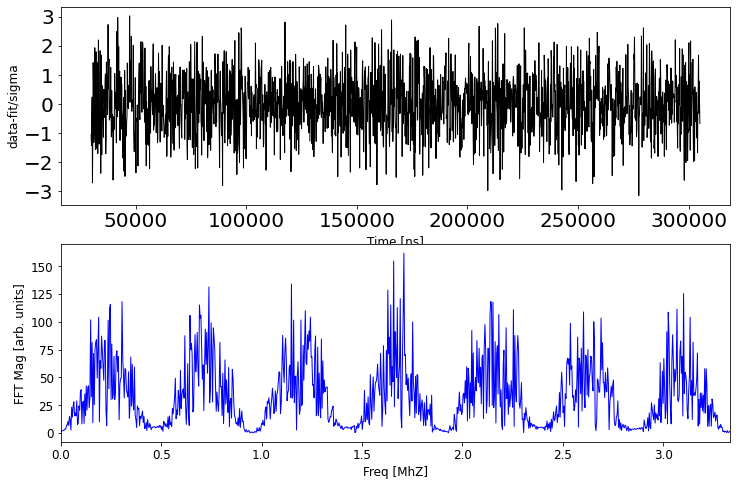

In [22]:
# Calculate the residuals
res = (y_val - fit_func(x_val, *pars_final))/y_err

fou=abs(np.fft.fft(res))

#xfft=np.empty(fit_range)
xfft= np.linspace(0,6.667,num=fit_range)



plt.figure(figsize=(12,8))
plt.subplot(211)
plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12) 
plt.plot(x_val, res, linestyle='solid', linewidth=1, color='black')
plt.xlabel('Time [ns]',fontsize=12)
plt.ylabel('data-fit/sigma',fontsize=12)
#plt.savefig('run2all_res.jpg')

plt.subplot(212)
#plt.figure(figsize=(12,8))
plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12) 
plt.plot(xfft, fou, linestyle='solid', linewidth=1, color='blue')
plt.xlim([0,6.667/2])
plt.xlabel('Freq [MhZ]',fontsize=12)
plt.ylabel('FFT Mag [arb. units]',fontsize=12)
#plt.savefig('run2all_fft.jpg')

In [23]:
chi2=np.dot((np.transpose(y_val-fit_func(x_val, *pars_final))),(np.dot((np.linalg.inv(y_cov)),(y_val-fit_func(x_val, *pars_final)))))
ndf=fit_range-len(pars_final)
red_chi2=chi2/ndf
red_chi2

0.9978365415380621

In [24]:
p_init_RW=[0.2282,
        0.000000,
        4.02000e+00,
        2.42604e-03,
        204100,
        2.331e-03,
        2.500e+00,
        0.0004,
        3.1,
        6.39026e-05,
        3.5,
        0.0007,
        57300,
        0.0139,
        2.7,
        0.0004,
        19000,
        0.01405,
        1.9,
        1.10668e-04,
        3.06805,
        7.7000e+08,
        0.00014,
        4.2]

In [25]:
pars2_RW, cov2_RW = opt.curve_fit(f=fit_func_RW, xdata=x_val, ydata=y_val, p0=p_init_RW, sigma=y_err)

In [26]:
p_init_RW=pars2_RW

In [27]:
pars_final_RW, cov_final_RW = opt.curve_fit(f=fit_func_RW, xdata=x_val, ydata=y_val, p0=p_init_RW, sigma=y_cov)

In [28]:
# Get the standard deviations of the parameters (square roots of the # diagonal of the covariance)
stdevs_RW = np.sqrt(np.diag(cov_final_RW))

In [29]:
for ipar in range(0,24):
    print(pars_final_RW[ipar],"       +-  ",stdevs_RW[ipar],"  \n")

0.22823755018945993        +-   2.0877997895993834e-05   

-34.00164433477751        +-   0.6120004481166181   

3.996705861122237        +-   9.32621223830007e-05   

-0.0011289078099821423        +-   3.3364443400159194e-05   

210232.21204682626        +-   16493.041977756424   

0.002331179208858564        +-   3.7481463848360324e-07   

2.5782802223166437        +-   0.029787264573812946   

-0.00036324290997599967        +-   9.992780753736199e-05   

2.2656348064062866        +-   0.27278301688054674   

0.00011840435369116242        +-   0.00010086717890139673   

1.5931788797245259        +-   0.8513098902170387   

-0.0007463278122556839        +-   0.00010642901512274387   

54705.84517455373        +-   7220.5849236115655   

0.013900288312555659        +-   2.404064810908839e-06   

2.6791823768810423        +-   0.14173964227257008   

0.0029547392463630836        +-   0.0005217768930431499   

21227.355603388845        +-   1908.2729336561408   

0.014049038482768667    

Text(0, 0.5, 'FFT Mag [arb. units]')

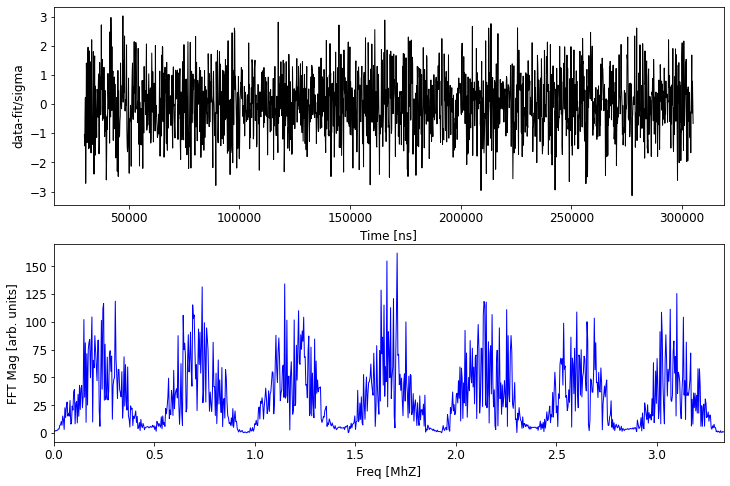

In [30]:
# Calculate the residuals
res_RW = (y_val - fit_func_RW(x_val, *pars_final_RW))/y_err

fou_RW=abs(np.fft.fft(res_RW))

#xfft=np.empty(fit_range)
xfft_RW= np.linspace(0,6.667,num=fit_range)



plt.figure(figsize=(12,8))
plt.subplot(211)
plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12) 
plt.plot(x_val, res_RW, linestyle='solid', linewidth=1, color='black')
plt.xlabel('Time [ns]',fontsize=12)
plt.ylabel('data-fit/sigma',fontsize=12)
#plt.savefig('run2all_res.jpg')

plt.subplot(212)
#plt.figure(figsize=(12,8))
plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12) 
plt.plot(xfft_RW, fou_RW, linestyle='solid', linewidth=1, color='blue')
plt.xlim([0,6.667/2])
plt.xlabel('Freq [MhZ]',fontsize=12)
plt.ylabel('FFT Mag [arb. units]',fontsize=12)
#plt.savefig('run2all_fft.jpg')

In [31]:
chi2_RW=np.dot((np.transpose(y_val-fit_func_RW(x_val, *pars_final_RW))),(np.dot((np.linalg.inv(y_cov)),(y_val-fit_func_RW(x_val, *pars_final_RW)))))
ndf_RW=fit_range-len(pars_final_RW)
red_chi2_RW=chi2_RW/ndf
red_chi2_RW

0.9973512833601776

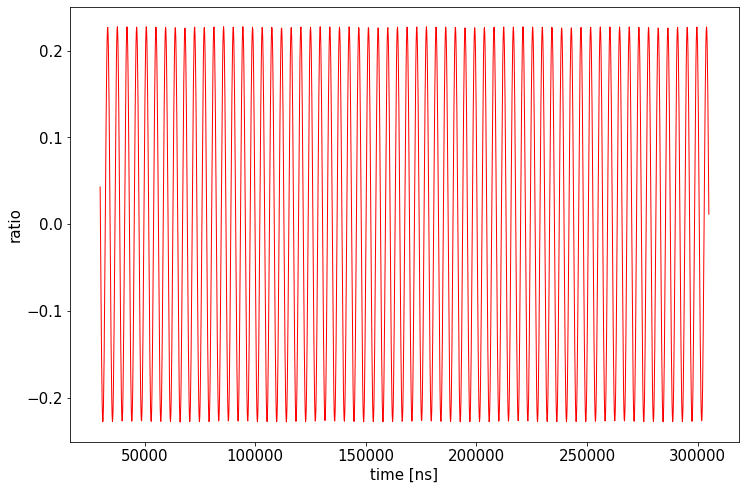

In [32]:
plt.figure(figsize=(12,8))
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 
plt.plot(x_val, fit_func_RW(x_val, *pars_final_RW), linestyle='solid', linewidth=1, color='red')
plt.xlabel('time [ns]',fontsize=15)
plt.ylabel('ratio',fontsize=15)
plt.show()

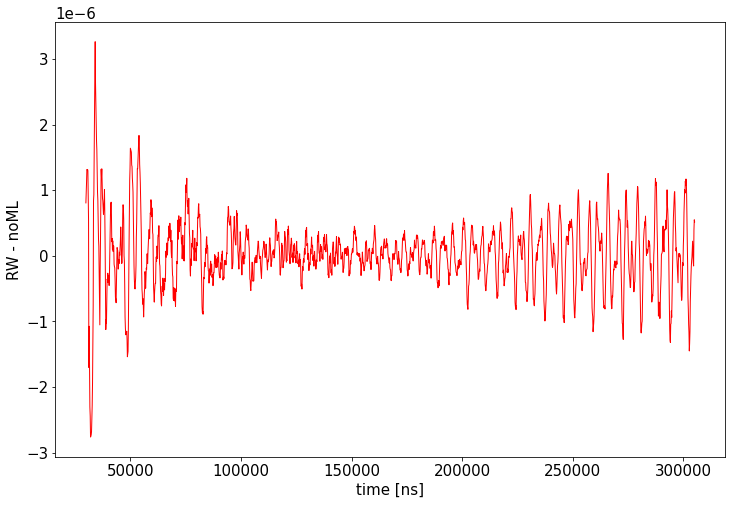

In [33]:
plt.figure(figsize=(12,8))
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 
plt.plot(x_val, (fit_func_RW(x_val, *pars_final_RW))-(fit_func(x_val, *pars_final)), linestyle='solid', linewidth=1, color='red')
plt.xlabel('time [ns]',fontsize=15)
plt.ylabel('RW - noML',fontsize=15)
#plt.ylim(0.99998,1.00002)
#plt.xlim(29000,40000)
plt.show()

In [34]:
p_init_RE=[0.2282,
        0.000000,
        4.02000e+00,
        2.42604e-03,
        204100,
        2.331e-03,
        2.500e+00,
        0.0004,
        3.1,
        6.39026e-05,
        3.5,
        0.0007,
        57300,
        0.0139,
        2.7,
        0.0004,
        19000,
        0.01405,
        1.9,
        1.10668e-04,
        3.06805,
        7.7000e+08,
        0.00014,
        4.2]

In [35]:
pars2_RE, cov2_RE = opt.curve_fit(f=fit_func_RE, xdata=x_val, ydata=y_val, p0=p_init_RE, sigma=y_err)

In [36]:
p_init_RE=pars2_RE

In [37]:
pars_final_RE, cov_final_RE = opt.curve_fit(f=fit_func_RE, xdata=x_val, ydata=y_val, p0=p_init_RE, sigma=y_cov)

In [38]:
# Get the standard deviations of the parameters (square roots of the # diagonal of the covariance)
stdevs_RE = np.sqrt(np.diag(cov_final_RE))

In [39]:
for ipar in range(0,24):
    print(pars_final_RE[ipar],"       +-  ",stdevs_RE[ipar],"  \n")

0.22823599686888532        +-   2.087029439429441e-05   

-33.98922281748854        +-   0.6117502119609023   

3.996700920100697        +-   9.323037342692729e-05   

-0.0011283334532137105        +-   3.333671637821417e-05   

210445.537854548        +-   16517.56626319025   

0.0023311922414350453        +-   3.746049671663129e-07   

2.5797832188834504        +-   0.02977832950249214   

-0.00036783023669681843        +-   9.986827112150921e-05   

2.270272296086508        +-   0.2692230972396843   

0.0001258168829362793        +-   0.00010075505091513605   

1.612244337651464        +-   0.8011027041211662   

-0.0007477457952321754        +-   0.00010659405097588466   

54639.891899803704        +-   7202.9047345510135   

0.013900313911534911        +-   2.403911600936905e-06   

2.6812470178652226        +-   0.14168722332689848   

0.0029624349321015894        +-   0.0005232833673929654   

21201.409225872747        +-   1904.6803305984226   

0.014049095716288422        +-  

Text(0, 0.5, 'FFT Mag [arb. units]')

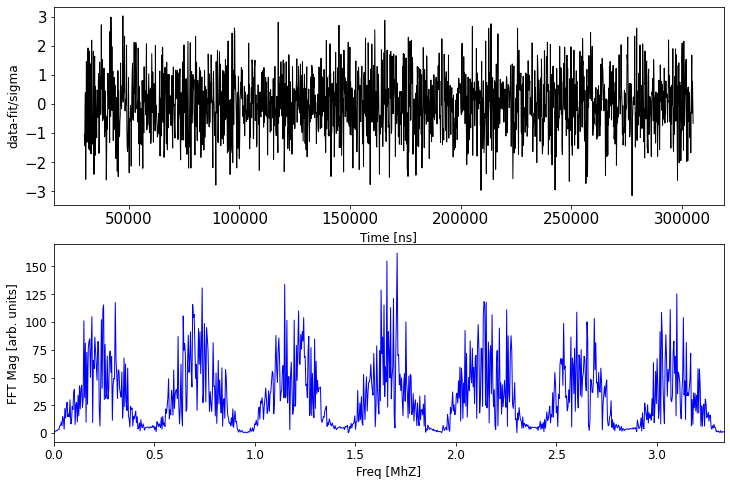

In [40]:
# Calculate the residuals
res_RE = (y_val - fit_func_RE(x_val, *pars_final_RE))/y_err

fou_RE=abs(np.fft.fft(res_RE))

#xfft=np.empty(fit_range)
xfft_RE= np.linspace(0,6.667,num=fit_range)



plt.figure(figsize=(12,8))
plt.subplot(211)
plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12) 
plt.plot(x_val, res_RE, linestyle='solid', linewidth=1, color='black')
plt.xlabel('Time [ns]',fontsize=12)
plt.ylabel('data-fit/sigma',fontsize=12)
#plt.savefig('run2all_res.jpg')

plt.subplot(212)
#plt.figure(figsize=(12,8))
plt.rc('xtick', labelsize=12) 
plt.rc('ytick', labelsize=12) 
plt.plot(xfft_RE, fou_RE, linestyle='solid', linewidth=1, color='blue')
plt.xlim([0,6.667/2])
plt.xlabel('Freq [MhZ]',fontsize=12)
plt.ylabel('FFT Mag [arb. units]',fontsize=12)
#plt.savefig('run2all_fft.jpg')

In [41]:
chi2_RE=np.dot((np.transpose(y_val-fit_func_RE(x_val, *pars_final_RE))),(np.dot((np.linalg.inv(y_cov)),(y_val-fit_func_RE(x_val, *pars_final_RE)))))
ndf_RE=fit_range-len(pars_final_RE)
red_chi2_RE=chi2_RE/ndf
red_chi2_RE

0.996681802312645

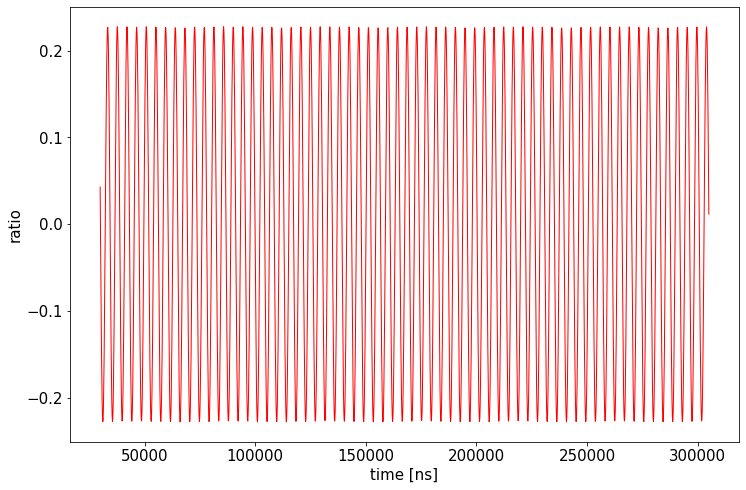

In [42]:
plt.figure(figsize=(12,8))
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 
plt.plot(x_val, fit_func_RE(x_val, *pars_final_RE), linestyle='solid', linewidth=1, color='red')
plt.xlabel('time [ns]',fontsize=15)
plt.ylabel('ratio',fontsize=15)
plt.show()

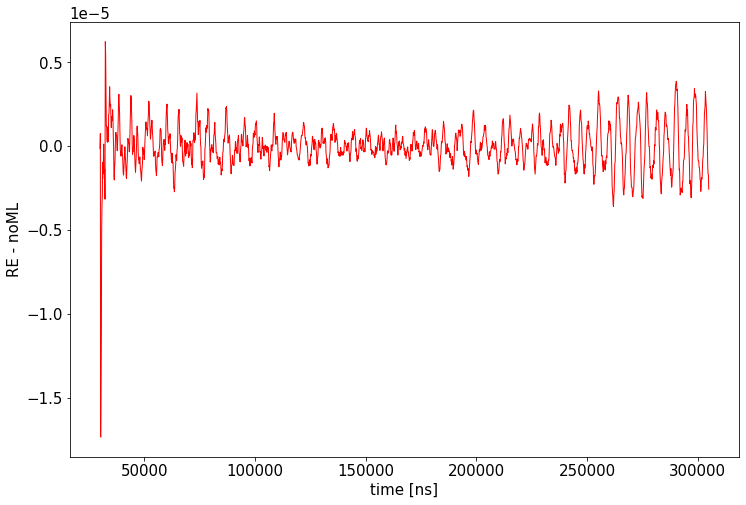

In [43]:
plt.figure(figsize=(12,8))
plt.rc('xtick', labelsize=15) 
plt.rc('ytick', labelsize=15) 
plt.plot(x_val, (fit_func_RE(x_val, *pars_final_RE))-(fit_func(x_val, *pars_final)), linestyle='solid', linewidth=1, color='red')
plt.xlabel('time [ns]',fontsize=15)
plt.ylabel('RE - noML',fontsize=15)
#plt.ylim(0.99998,1.00002)
#plt.xlim(29000,40000)
plt.show()

In [44]:
pars_final_RE[1]-pars_final[1]

-0.004020209228741578

In [45]:
pars_final_RW[1]-pars_final[1]

-0.01644172651771214